# Configuration

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read packages

In [ ]:
import json, math, random, time, zipfile, io
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
import copy

from types import SimpleNamespace
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torchvision import transforms, models
from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

from dataclasses import dataclass, field

import os
import sys
import warnings

warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

sys.path.append("..")

from src.data_utils import *
from src.cnn_models import *
from src.training_utils import *
from src.evaluation_utils import *

Device: cpu


## Read data-images

In [15]:
filename = "cnn_personalized.ipynb"  # Name of current file
print(f"Current absolute path: {os.getcwd()}\n")

# We specify the path of the current directory and the data and output directories.
ACTUAL_DIR = os.path.dirname(os.path.abspath(filename))
BASE_DIR = os.path.dirname(ACTUAL_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
IMG_DIR = os.path.join(DATA_DIR, "images")
OUTPUT_DIR = os.path.join(DATA_DIR, "output")

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"IMG_DIR: {IMG_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

Current absolute path: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/notebooks

BASE_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA
DATA_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/data
IMG_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/data/images
OUTPUT_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendi

In [16]:
# Read the CSV file
csv_file = os.path.join(DATA_DIR, "train.csv")
df_train_complete = pd.read_csv(csv_file)

## Init params
Base parameters and classes to use downstream.

In [61]:
# Data related params
prct_train = 0.8
img_size = 256
weight_cap = 5  # for positive weight, to avoid too large weights


# Class related params
@dataclass
class TrainConfig:
    img_size: int = 256
    batch_size: int = 16
    epochs: int = 10
    lr: float = 1e-4  # Learning rate
    weight_decay: float = 1e-4  # Weight decay for optimizer
    positive_weight: float = 1.0  # Weight for positive class in classification loss
    cls_loss_w: float = 1.0  # Weight for classification loss
    box_loss_w: float = 2.0  # Weight for bounding box loss
    beta_smoothl1: float = 1.0  # beta parameter for SmoothL1Loss
    es_patience: int = 5  # Early stopping patience
    monitor: str = "val_iou"  # "val_loss" | "val_iou" | "val_score"
    alpha_score: float = 0.7  # If use "val_score": score = alpha*IoU + (1-alpha)*ACC
    cnn_name: str = "cnn"  # Name of the CNN model
    output_dir: str = OUTPUT_DIR  # Directory to save models and logs
    logging_step: int = 5  # For logging every n steps
    verbose: bool = True  # Whether to print logs

# Prepare data
Divide train and valid data.  
Build the Datasets objects.

In [62]:
# Compute the weight of positive classes.
# This will be useful whether the df is desbalanced
# and for downstream training tasks

# Use a weight cap to avoid too large weights

if DEFAULT_COLS["class"] in df_train_complete.columns:
    # Calculate class counts
    counts = (
        df_train_complete[DEFAULT_COLS["class"]]
        .str.lower()
        .map(CLASS_TO_LABEL)
        .value_counts()
    )
    print("Class counts:", counts.to_dict())

    # Calculate pos_weight
    pos = float(counts.get(1, 1.0))
    neg = float(counts.get(0, 1.0))
    positive_weight = torch.tensor(
        [min(weight_cap, max(1.0, neg / max(1.0, pos)))], device=DEVICE
    )
    print("Calculated positive_weight:", positive_weight.item())
else:
    print(
        "Warning: 'class' column not found in DataFrame. Skipping pos_weight calculation."
    )

Class counts: {0: 135, 1: 84}
Calculated positive_weight: 1.6071428060531616


In [63]:
# split the data into train and valid
n = len(df_train_complete)
n_train = math.floor(prct_train * n)
n_valid = n - n_train

# Shuffle and split
df_shuffled = df_train_complete.sample(frac=1, random_state=42).reset_index(drop=True)
df_valid = df_shuffled.iloc[n_train:].reset_index(drop=True)
df_train = df_shuffled.iloc[:n_train].reset_index(drop=True)

print(f"Total samples: {n}, Train samples: {n_train}, Validation samples: {n_valid}")

Total samples: 219, Train samples: 175, Validation samples: 44


In [64]:
## Build the Datasets
# In this case, we will use personalized normalization

# Compute the mean and std per channel (R, G, B) across all training images
mean_train_images, std_train_images = compute_mean_std_image_dir(
    IMG_DIR, df_train["filename"].tolist()
)

# Create the datasets with personalized normalization
train_dataset = MaskDataset(
    df=df_train,
    images_dir=IMG_DIR,
    img_size=img_size,
    personalized_norm=True,
    custom_mean=mean_train_images,
    custom_std=std_train_images,
)

# Use the same normalization of training to avoid data leakage
valid_dataset = MaskDataset(
    df=df_valid,
    images_dir=IMG_DIR,
    img_size=img_size,
    personalized_norm=True,
    custom_mean=mean_train_images,
    custom_std=std_train_images,
)

# Base CNN 
Evaluate a basic backbone + basic decision head.  

In [69]:
# Base CNN architecture params
base_ch = 16  # base number of channels
out_dim = 128  # output feature dimension from the backbone
prct_dropout = 0.3  # dropout percentage

# Base training params
lr_base = 1e-4
weight_decay_base = 1e-4

# Instantiate the base model
base_backbone = BaseBackbone(base_ch=base_ch, out_dim=out_dim)

# Wrap the backbone and add the decision head
base_cnn_arch = TwoHeadNetVOC(
    backbone=base_backbone, feat_dim=out_dim, dropout=prct_dropout
).to(DEVICE)

# Define the optimizer and the accuracy metric
optimizer = torch.optim.AdamW(
    base_cnn_arch.parameters(), lr=lr_base, weight_decay=weight_decay_base
)
acc_metric = BinaryAccuracy().to(DEVICE)

# Model summary
summary(base_cnn_arch, (3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                  [-1, 128]           8,320
      BaseBackbone-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
           Linear-14                   

In [ ]:
# Define the configuration dictionary
cfg = TrainConfig(
    img_size=img_size,
    batch_size=16,
    epochs=50,
    lr=lr_base,
    es_patience=5,
    cls_loss_w=1.0,
    box_loss_w=1.5,
    monitor="val_score",  # options: "val_loss", "val_iou", "val_score"
    positive_weight=torch.tensor(1).to(DEVICE),
    cnn_name="cnn_base",
)

# Instantiate the trainer
base_model = Trainer_base(
    base_cnn_arch,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    optimizer=optimizer,
    cfg=cfg,
    device=DEVICE,
)

# Start the training
history_base_model = base_model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(base_model)

/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.6139, acc: 0.394, IoU: 0.000 | Valid -- loss: 1.6201, acc: 0.341, IoU: 0.000 | Monitor(val_score): 0.1023
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.5845, acc: 0.389, IoU: 0.005 | Valid -- loss: 1.5836, acc: 0.318, IoU: 0.008 | Monitor(val_score): 0.1011
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.2758, acc: 0.606, IoU: 0.297 | Valid -- loss: 1.2421, acc: 0.659, IoU: 0.296 | Monitor(val_score): 0.4049
Epoch 015 | LR 1.00e-04 | Train -- loss: 1.2600, acc: 0.606, IoU: 0.307 | Valid -- loss: 1.2370, acc: 0.659, IoU: 0.313 | Monitor(val_score): 0.4168
Epoch 020 | LR 1.00e-04 | Train -- loss: 1.2594, acc: 0.600, IoU: 0.310 | Valid -- loss: 1.2366, acc: 0.659, IoU: 0.314 | Monitor(val_score): 0.4176
Epoch 025 | LR 1.00e-04 | Train -- loss: 1.2587, acc: 0.600, IoU: 0.311 | Valid -- loss: 1.2361, acc: 0.659, IoU: 0.316 | Monitor(val_score): 0.4186
Epoch 030 | LR 1.00e-04 | Train -- loss: 1.2521, acc: 0.600, IoU: 0.311 | Valid -- loss: 1.2304, acc: 0.65

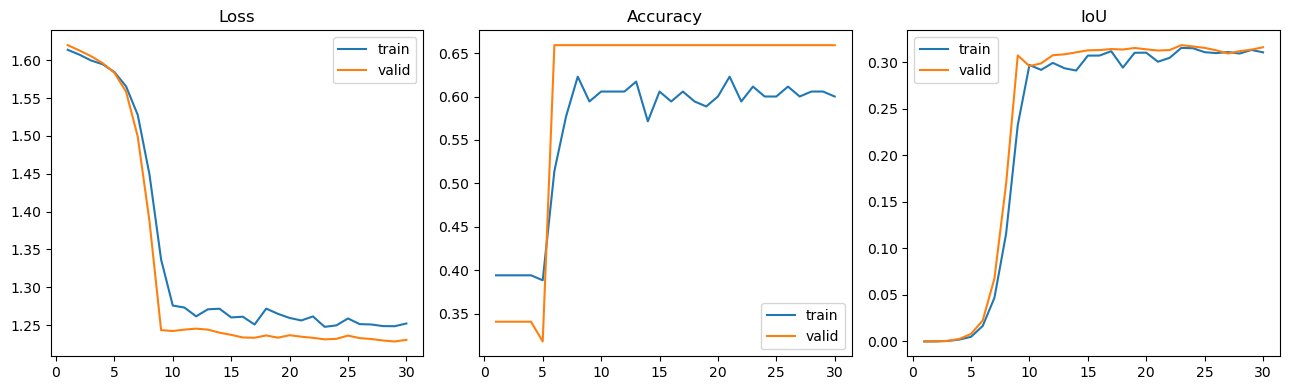

In [71]:
# Plot the training history
plot_history(history_base_model, figsize=(13, 4))

# of images selected: 5


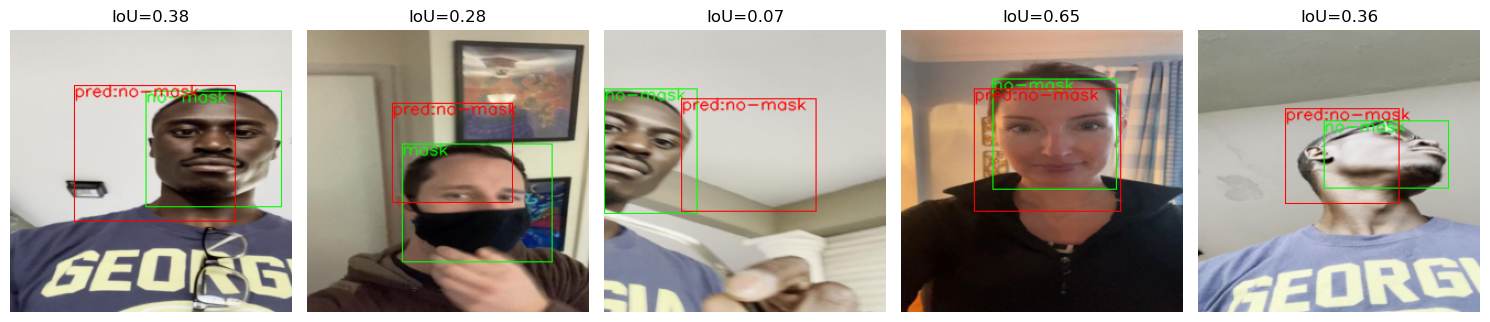

In [72]:
# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_base", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=base_cnn_arch,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [ ]:
# Free up memory
del base_model
del base_cnn_arch

We can note that the classification task is not working correctly, nor is the regression task.  
**This base model is very deficient**, and from this point on, the goal is to continue improving the performance of our convolutional neural network.

# Tunning the base model

## Improve the backbone architecture
Tests with different hidden layers distribution and useful modules

### Backbone #2 - lite

- Lighter architecture, only 2 convolutional layers, global avg pooling (1) and dropout in both backbone and desicion head.  
- Use the same configuration of base example.

In [ ]:
# Lite backbone - Smaller and faster
backbone_simple = liteBackbone(base_ch=16, out_dim=128, dropout=0.5)
cnn_arch_2 = TwoHeadNetVOC(backbone=backbone_simple, feat_dim=128, dropout=0.3).to(
    DEVICE
)

# Optimizer and accuracy metric instantiate inside the Trainer class

# Define the configuration dictionary - same as base configuration
cfg2 = cfg
cfg2.cnn_name = "cnn_simple"

# Model summary
summary(cnn_arch_2, (3, cfg2.img_size, cfg2.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
              ReLU-4           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-5             [-1, 32, 1, 1]               0
           Flatten-6                   [-1, 32]               0
           Dropout-7                   [-1, 32]               0
            Linear-8                  [-1, 128]           4,224
      liteBackbone-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
           Linear-14                   

In [ ]:
# Instantiate the trainer - same datasets
model = Trainer_base(
    cnn_arch_2,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    cfg=cfg2,
    device=DEVICE,
)

# Start the training
history_model_cnn_lite = model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(model)

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.6322, acc: 0.554, IoU: 0.000 | Valid -- loss: 1.6257, acc: 0.659, IoU: 0.000 | Monitor(val_score): 0.1977
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.5943, acc: 0.617, IoU: 0.004 | Valid -- loss: 1.5895, acc: 0.659, IoU: 0.004 | Monitor(val_score): 0.2006
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.4086, acc: 0.606, IoU: 0.165 | Valid -- loss: 1.3495, acc: 0.659, IoU: 0.207 | Monitor(val_score): 0.3428
Epoch 015 | LR 1.00e-04 | Train -- loss: 1.2685, acc: 0.611, IoU: 0.291 | Valid -- loss: 1.2443, acc: 0.659, IoU: 0.300 | Monitor(val_score): 0.4081
Epoch 020 | LR 1.00e-04 | Train -- loss: 1.2509, acc: 0.594, IoU: 0.306 | Valid -- loss: 1.2410, acc: 0.659, IoU: 0.303 | Monitor(val_score): 0.4102
Epoch 025 | LR 1.00e-04 | Train -- loss: 1.2645, acc: 0.611, IoU: 0.301 | Valid -- loss: 1.2413, acc: 0.659, IoU: 0.302 | Monitor(val_score): 0.4094

Early stopping at epoch 26:

Best val_score: 0.4112
Train: loss: 1.2601, acc: 0.600, IoU: 0.300
Valid: lo

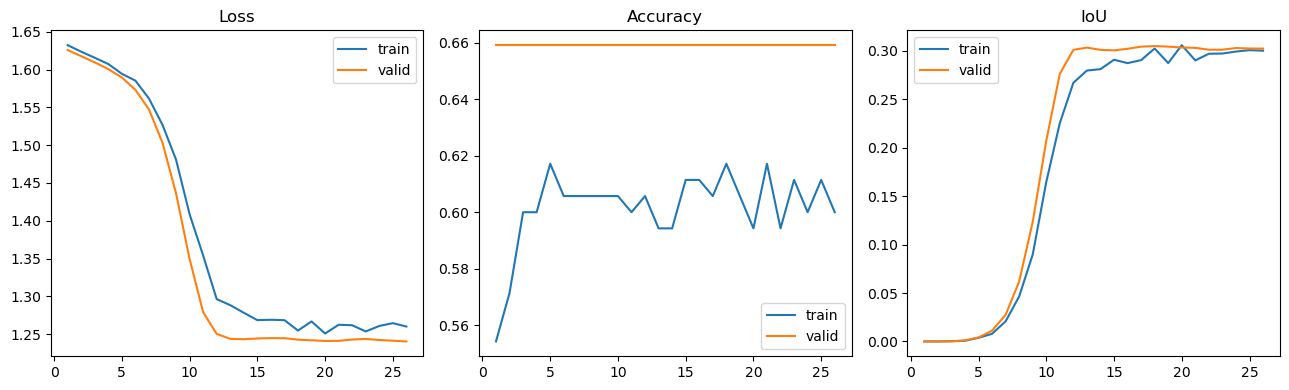

# of images selected: 5


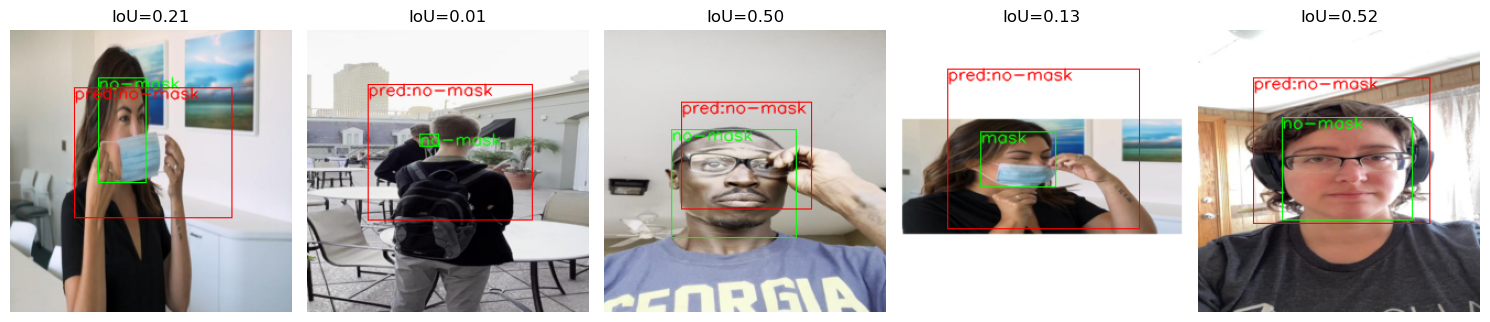

In [ ]:
# Plot the training history
plot_history(history_model_cnn_lite, figsize=(13, 4))


# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_base", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=cnn_arch_2,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [ ]:
# Free up memory
del model
del cnn_arch_2

### Backbone #3 - Robust

- Deeper architecture: multiple convolution → batch norm → ReLU blocks, with progressive channel increase (c → 2c → 4c).
- **Stride convolutions** instead of max pooling.
- **Batch Normalization** after each convolution.
- AdaptiveAvgPool2d(g_pool) → **global average pooling**, outputs a fixed-size feature vector regardless of input image size.  
Output with size g_pool x g_pool to retain some spacial information.
- Dropout after global pooling.
- Use the same configuration of base example.

In [ ]:
# Lite backbone - Smaller and faster
backbone_robust = RobustBackbone(base_ch=32, out_dim=256, dropout=0.5, g_pool=3)
cnn_arch_3 = TwoHeadNetVOC(backbone=backbone_robust, feat_dim=256, dropout=0.3).to(
    DEVICE
)

# Optimizer and accuracy metric instantiate inside the Trainer class (using cfg)

# Define the configuration dictionary - same as base configuration
cfg3 = cfg
cfg3.cnn_name = "cnn_robust"

# Model summary
summary(cnn_arch_3, (3, cfg3.img_size, cfg3.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
              ReLU-4           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-5             [-1, 32, 1, 1]               0
           Flatten-6                   [-1, 32]               0
           Dropout-7                   [-1, 32]               0
            Linear-8                  [-1, 128]           4,224
      liteBackbone-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
           Linear-14                   

In [ ]:
# Instantiate the trainer - same datasets
model = Trainer_base(
    cnn_arch_3,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    cfg=cfg3,
    device=DEVICE,
)

# Start the training
history_model_cnn_robust = model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(model)

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.6322, acc: 0.554, IoU: 0.000 | Valid -- loss: 1.6257, acc: 0.659, IoU: 0.000 | Monitor(val_score): 0.1977
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.5943, acc: 0.617, IoU: 0.004 | Valid -- loss: 1.5895, acc: 0.659, IoU: 0.004 | Monitor(val_score): 0.2006
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.4086, acc: 0.606, IoU: 0.165 | Valid -- loss: 1.3495, acc: 0.659, IoU: 0.207 | Monitor(val_score): 0.3428
Epoch 015 | LR 1.00e-04 | Train -- loss: 1.2685, acc: 0.611, IoU: 0.291 | Valid -- loss: 1.2443, acc: 0.659, IoU: 0.300 | Monitor(val_score): 0.4081
Epoch 020 | LR 1.00e-04 | Train -- loss: 1.2509, acc: 0.594, IoU: 0.306 | Valid -- loss: 1.2410, acc: 0.659, IoU: 0.303 | Monitor(val_score): 0.4102
Epoch 025 | LR 1.00e-04 | Train -- loss: 1.2645, acc: 0.611, IoU: 0.301 | Valid -- loss: 1.2413, acc: 0.659, IoU: 0.302 | Monitor(val_score): 0.4094

Early stopping at epoch 26:

Best val_score: 0.4112
Train: loss: 1.2601, acc: 0.600, IoU: 0.300
Valid: lo

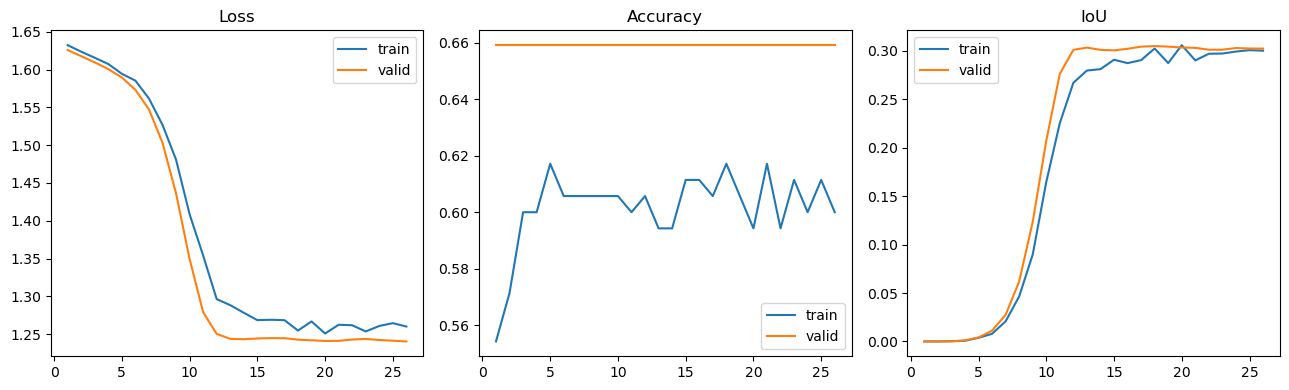

# of images selected: 5


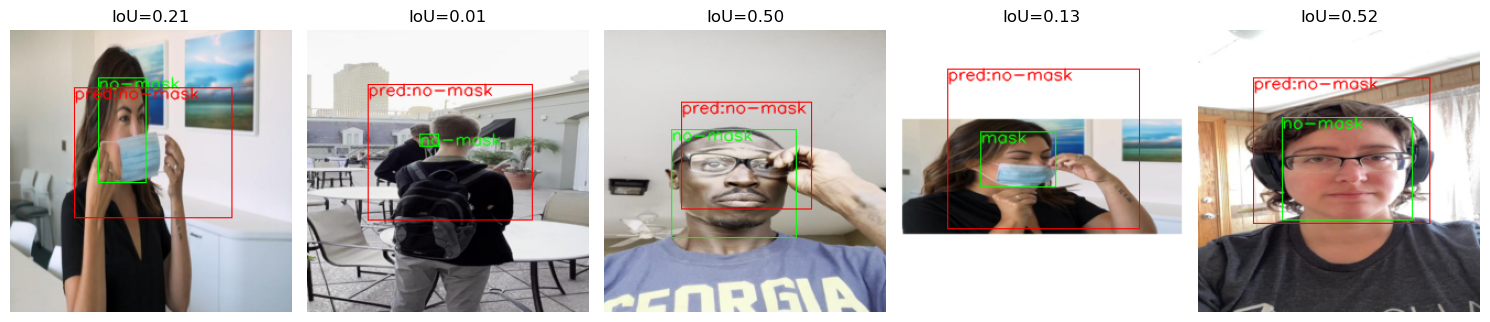

In [ ]:
# Plot the training history
plot_history(history_model_cnn_robust, figsize=(13, 4))


# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_base", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=cnn_arch_3,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [ ]:
# Free up memory
del model
del cnn_arch_3

## Improve the desicion head architecture
Add more layers or useful modules

## Hiperparameter tunning
Test the results by tunning different values of hiperparameters:
- d
- d

Also add a shceduler (to reduce de LR progresively)

## Test Data augmentations
Use different data augmentation techniques and identify those who are better to improve the performance.

# Compare the results
Show the metrics of the different models and compare the predictions on the images (validation data)

# Conclusions

----

In [ ]:
# # Ejemplo

# backbone = BaseBackbone()

# # Add an extra conv layer at the end of self.body
# extra_layer = nn.Sequential(
#     nn.Conv2d(4*32, 8*32, 3, 1, 1),
#     nn.BatchNorm2d(8*32),
#     nn.ReLU(inplace=True),
# )

# # Concatenate to the existing body
# backbone.body = nn.Sequential(
#     *(list(backbone.body.children()) + list(extra_layer.children()))
# )

In [ ]:
# # ejemplo

# backbone = BaseBackbone()

# # Replace projection with a deeper MLP
# backbone.proj = nn.Sequential(
#     backbone.proj,                      # original linear layer
#     nn.ReLU(inplace=True),
#     nn.Linear(backbone.proj.out_features, 256),  # new layer
# )